In [1]:
#Importing the required libraries

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")
from IPython.display import HTML,display

warnings.filterwarnings("ignore")

In [2]:
#Read the daily city-wise data
df= pd.read_csv("city_day.csv",parse_dates=True)
df['Date'] = pd.to_datetime(df['Date'])

In [3]:
#Keeping only the columns needed
df=df[['City','Date','AQI']]

In [4]:
#Filtering the dataframe to keep the data for the city of Delhi only
delhi = df[df['City'] == 'Delhi']
delhi.drop(['City'],axis=1,inplace = True)
delhi.set_index('Date', inplace = True)


In [5]:
delhi

,AQI
Date,
2015-01-01,472.0
2015-01-02,454.0
2015-01-03,143.0
2015-01-04,319.0
2015-01-05,325.0
...,...
2020-06-27,112.0
2020-06-28,196.0
2020-06-29,233.0


In [6]:
#Fill NULL DATA
delhi['AQI'].fillna(method = 'bfill',inplace = True)

In [7]:
#Taking monthly average
delhi=delhi.astype('float64')
delhi=delhi.resample(rule='MS').mean()

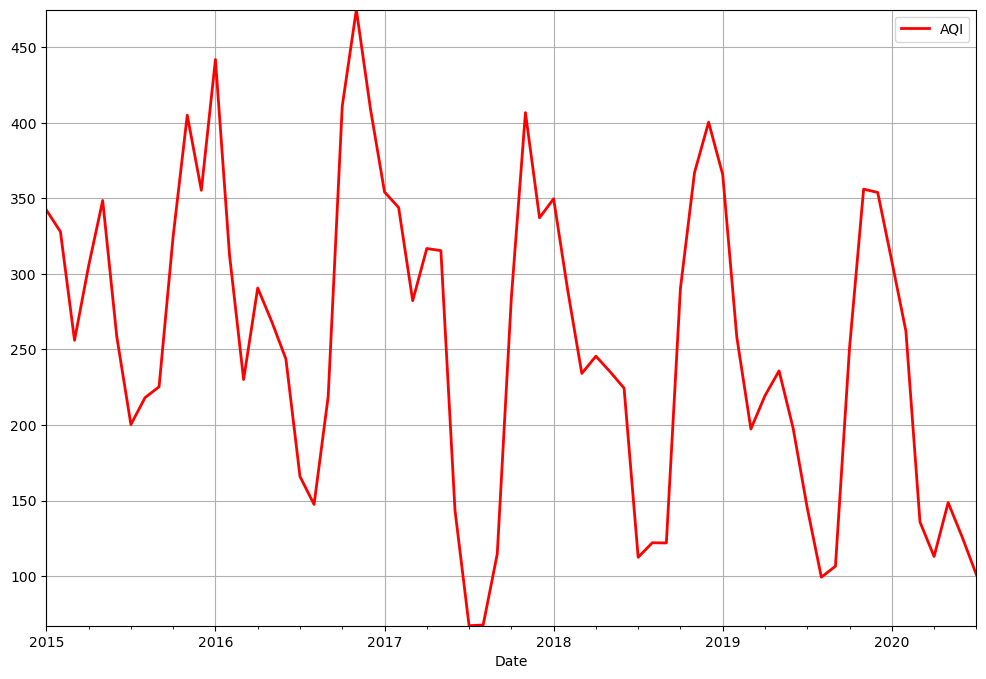

In [8]:
ax=delhi[['AQI']].plot(figsize=(12,8),grid=True,lw=2,color='Red')
ax.autoscale(enable=True, axis='both', tight=True)

# FORECASTING


In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error

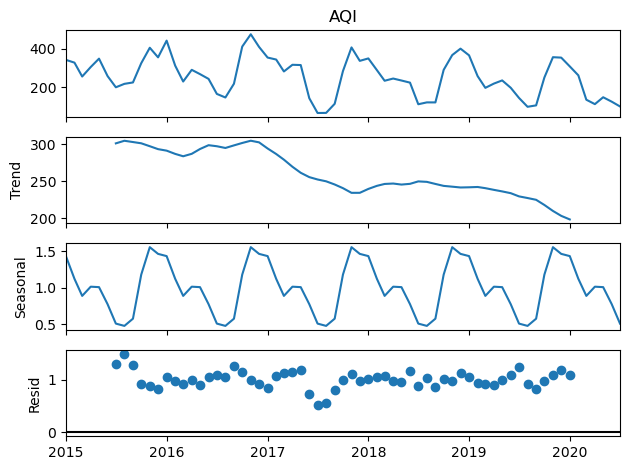

In [10]:
delhi_AQI=delhi['AQI']
result=seasonal_decompose(delhi_AQI,model='multiplicative')
result.plot();

# **SARIMAX MODEL**

In [11]:
#Importing the SARIMAX Model
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [12]:
len(delhi_AQI)

67

In [13]:
#Splitting the training and testing dataset
train=delhi_AQI[:48]
test=delhi_AQI[48:61]

In [14]:
#Defining our model and fitting on the training data
model=SARIMAX(train,order=(0,1,3),seasonal_order=(0,1,1,12))
results=model.fit()
results.summary()

C:\Users\arund\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                  AQI   No. Observations:                   48
Model:             SARIMAX(0, 1, 3)x(0, 1, [1], 12)   Log Likelihood                -185.444
Date:                              Mon, 17 Jun 2024   AIC                            380.888
Time:                                      12:35:00   BIC                            388.665
Sample:                                  01-01-2015   HQIC                           383.573
                                       - 12-01-2018                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5598     11.528     -0.049      0.961     -23.155      22.035
ma.L2         -0.0811      5.099     -0.016      0.987     -10.075       9.913
ma.L3         -0.3565      4.268     -0.084      0.933      -8.722       8.009
ma.S.L12      -0.9985    173.909     -0.006      0.995    -341.854     339.857
sigma2      1324.3250   2.29e+05      0.006      0.995   -4.48e+05    4.51e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.63   Jarque-Bera (JB):                 0.24
Prob(Q):                              0.43   Prob(JB):                         0.89
Heteroskedasticity (H):               0.54   Skew:                             0.20
Prob(H) (two-sided):                  0.29   Kurtosis:                         3.01
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [15]:
#Predicting on our train and test dataset
train_predictions = results.predict(start=1, end=48, typ='levels').rename('Predictions')
test_predictions = results.predict(start=48, end=60, typ='levels').rename('Predictions')

<Axes: xlabel='Date'>

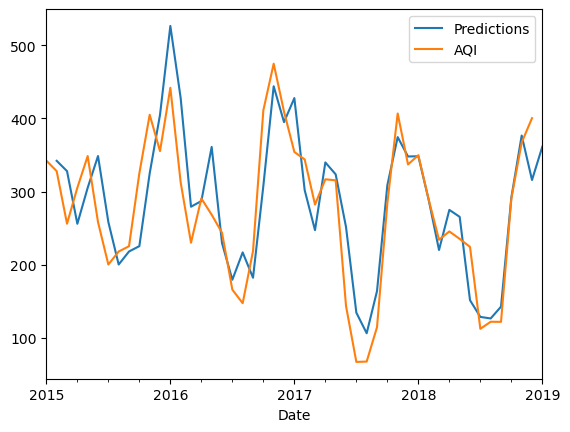

In [16]:
#Plotting the train predictions to see the fit of the model
train_predictions.plot(legend=True)
train.plot(legend=True)

In [17]:
#Calculating the RMSE value on the training dataset 
RMSE=np.sqrt(mean_squared_error(train_predictions,train))
print('RMSE = ',RMSE)
print('Mean AQI',train.mean())

RMSE =  66.39279014434844
Mean AQI 275.1711046334552


<Axes: xlabel='Date'>

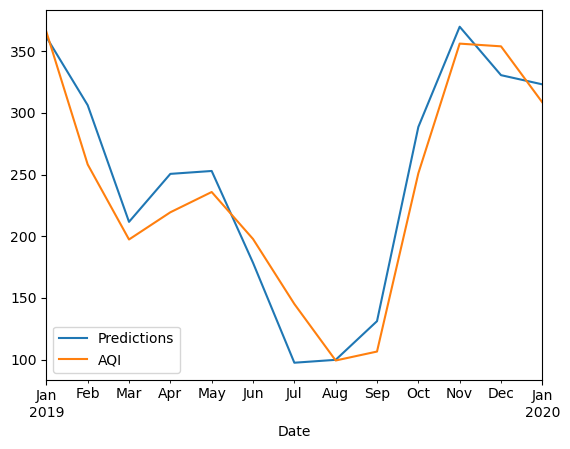

In [18]:
#Plotting the test predictions to see how well our model generalized
test_predictions.plot(legend=True)
test.plot(legend=True)

In [19]:
#Calculating the RMSE value on the testing dataset 
RMSE=np.sqrt(mean_squared_error(test_predictions,test))
print('RMSE = ',RMSE)
print('Mean AQI',test.mean())

RMSE =  26.881453835624132
Mean AQI 238.0504608294931


<Axes: xlabel='Date'>

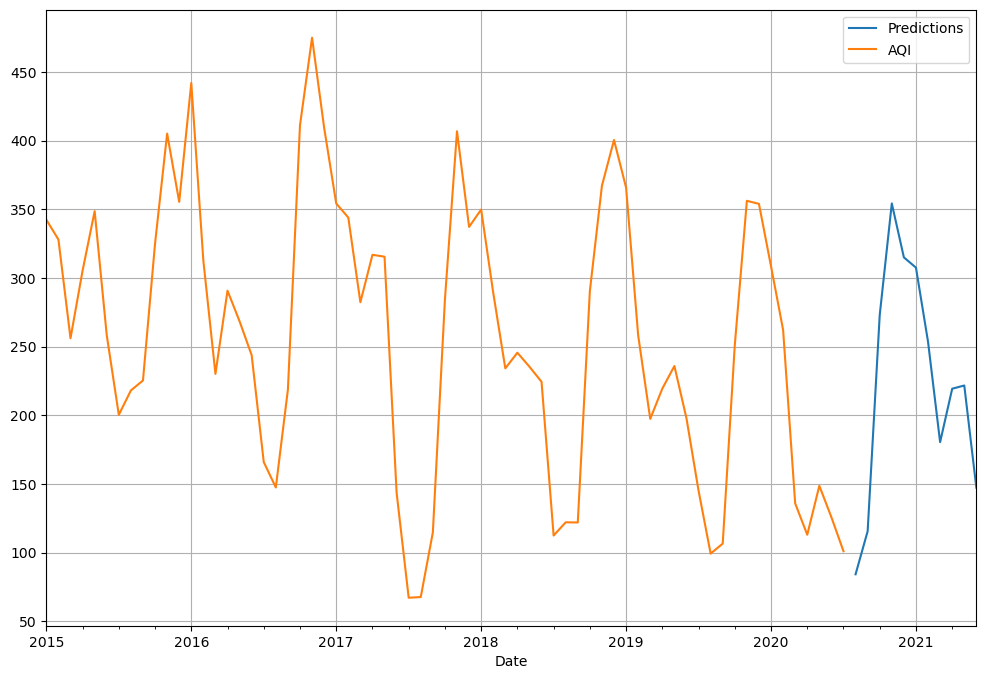

In [20]:
#Obtaining predicted values:
future_predictions = results.predict(start=67, end=77, typ='levels').rename('Predictions')

#Plotting predicted values against the true values:
future_predictions.plot(legend=True)
delhi_AQI.plot(legend=True,figsize=(12,8),grid=True)

### GRID search framework for fine tuning the model

In [21]:
def grid_search(p,d,q,P,D,Q,m,train,test):
    
    column_names = ['p','d','q','P','D','Q','m','RMSE_train','RMSE_test']
    df = pd.DataFrame(columns = column_names)

    for p1 in p:
        for p2 in d:
            for p3 in q:
                for p4 in P:
                    for p5 in D:
                        for p6 in Q:
                            for p7 in m:
                                
                                
                                model=SARIMAX(train,order=(p1,p2,p3),seasonal_order=(p4,p5,p6,p7))
                                try:
                                    results=model.fit()
                                except:
                                    print("Passing on : " + str(p1) + " " + str(p2) + " " + str(p3) + " " + str(p4) + " " + str(p5) + " " + str(p6) + " " + str(p7))
                                    pass
                                print("Fitting on : " + str(p1) + " " + str(p2) + " " + str(p3) + " " + str(p4) + " " + str(p5) + " " + str(p6) + " " + str(p7))
                                #results.summary()
                                #Predicting on our train and test dataset
                                train_predictions = results.predict(start=1, end=48, typ='levels').rename('Predictions')
                                test_predictions = results.predict(start=48, end=60, typ='levels').rename('Predictions')
                                
                                #Calculating the RMSE value on the training dataset 
                                RMSE_train = np.sqrt(mean_squared_error(train_predictions,train))
                                #Calculating the RMSE value on the testing dataset 
                                RMSE_test=np.sqrt(mean_squared_error(test_predictions,test))
                                
                                #Fill our dataframe
                                df = df.append({'p':p1, 'd':p2,'q':p3,
                                                'P':p4,'D':p5,'Q':p6,'m':p7,
                                                'RMSE_train' : RMSE_train, 'RMSE_test' : RMSE_test},
                                               ignore_index = True)
                                print(df.tail(1))
                                
                                
                                
    return df

In [25]:

# Example usage
train = delhi_AQI[:48]
test = delhi_AQI[48:61]

p = [0, 1]
d = [0, 1]
q = [0, 1]
P = [0, 1]
D = [0, 1]
Q = [0, 1]
m = [12]


table = grid_search(p, d, q, P, D, Q, m, train, test)
print(table)

Fitting on : 0 0 0 0 0 0 12
Fitting on : 0 0 0 0 0 1 12
Fitting on : 0 0 0 0 1 0 12
Fitting on : 0 0 0 0 1 1 12
Fitting on : 0 0 0 1 0 0 12
Fitting on : 0 0 0 1 0 1 12


C:\Users\arund\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\arund\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fitting on : 0 0 0 1 1 0 12
Fitting on : 0 0 0 1 1 1 12
Fitting on : 0 0 1 0 0 0 12
Fitting on : 0 0 1 0 0 1 12


C:\Users\arund\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fitting on : 0 0 1 0 1 0 12
Fitting on : 0 0 1 0 1 1 12
Fitting on : 0 0 1 1 0 0 12
Fitting on : 0 0 1 1 0 1 12


C:\Users\arund\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fitting on : 0 0 1 1 1 0 12
Fitting on : 0 0 1 1 1 1 12
Fitting on : 0 1 0 0 0 0 12
Fitting on : 0 1 0 0 0 1 12
Fitting on : 0 1 0 0 1 0 12
Fitting on : 0 1 0 0 1 1 12


C:\Users\arund\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fitting on : 0 1 0 1 0 0 12
Fitting on : 0 1 0 1 0 1 12
Fitting on : 0 1 0 1 1 0 12
Fitting on : 0 1 0 1 1 1 12
Fitting on : 0 1 1 0 0 0 12
Fitting on : 0 1 1 0 0 1 12


C:\Users\arund\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fitting on : 0 1 1 0 1 0 12
Fitting on : 0 1 1 0 1 1 12
Fitting on : 0 1 1 1 0 0 12
Fitting on : 0 1 1 1 0 1 12
Fitting on : 0 1 1 1 1 0 12
Fitting on : 0 1 1 1 1 1 12
Fitting on : 1 0 0 0 0 0 12
Fitting on : 1 0 0 0 0 1 12


C:\Users\arund\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fitting on : 1 0 0 0 1 0 12
Fitting on : 1 0 0 0 1 1 12
Fitting on : 1 0 0 1 0 0 12
Fitting on : 1 0 0 1 0 1 12
Fitting on : 1 0 0 1 1 0 12
Fitting on : 1 0 0 1 1 1 12
Fitting on : 1 0 1 0 0 0 12
Fitting on : 1 0 1 0 0 1 12


C:\Users\arund\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fitting on : 1 0 1 0 1 0 12
Fitting on : 1 0 1 0 1 1 12
Fitting on : 1 0 1 1 0 0 12
Fitting on : 1 0 1 1 0 1 12


C:\Users\arund\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fitting on : 1 0 1 1 1 0 12
Fitting on : 1 0 1 1 1 1 12
Fitting on : 1 1 0 0 0 0 12
Fitting on : 1 1 0 0 0 1 12
Fitting on : 1 1 0 0 1 0 12
Fitting on : 1 1 0 0 1 1 12


C:\Users\arund\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fitting on : 1 1 0 1 0 0 12
Fitting on : 1 1 0 1 0 1 12
Fitting on : 1 1 0 1 1 0 12
Fitting on : 1 1 0 1 1 1 12
Fitting on : 1 1 1 0 0 0 12
Fitting on : 1 1 1 0 0 1 12


C:\Users\arund\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fitting on : 1 1 1 0 1 0 12
Fitting on : 1 1 1 0 1 1 12
Fitting on : 1 1 1 1 0 0 12
Fitting on : 1 1 1 1 0 1 12
Fitting on : 1 1 1 1 1 0 12
Fitting on : 1 1 1 1 1 1 12
    p  d  q  P  D  Q   m  RMSE_train   RMSE_test
0   0  0  0  0  0  0  12  292.310975  253.392258
1   0  0  0  0  0  1  12  292.307671  253.392258
2   0  0  0  0  1  0  12  161.787174   29.513427
3   0  0  0  0  1  1  12  160.598873   41.140799
4   0  0  0  1  0  0  12  160.961973   20.603396
.. .. .. .. .. .. ..  ..         ...         ...
59  1  1  1  0  1  1  12   75.566179   28.557200
60  1  1  1  1  0  0  12   77.203943   94.866874
61  1  1  1  1  0  1  12   73.842980   24.826499
62  1  1  1  1  1  0  12   80.758609   42.799728
63  1  1  1  1  1  1  12   78.468643   39.429517

[64 rows x 9 columns]


In [26]:
table

,p,d,q,P,D,Q,m,RMSE_train,RMSE_test
0,0,0,0,0,0,0,12,292.310975,253.392258
1,0,0,0,0,0,1,12,292.307671,253.392258
2,0,0,0,0,1,0,12,161.787174,29.513427
3,0,0,0,0,1,1,12,160.598873,41.140799
4,0,0,0,1,0,0,12,160.961973,20.603396
...,...,...,...,...,...,...,...,...,...
59,1,1,1,0,1,1,12,75.566179,28.557200
60,1,1,1,1,0,0,12,77.203943,94.866874
61,1,1,1,1,0,1,12,73.842980,24.826499
62,1,1,1,1,1,0,12,80.758609,42.799728


In [27]:
table.to_csv("grid-search-results.csv")